<a href="https://colab.research.google.com/github/Nacho2904/AnalisisNumerico/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Curso Schwarz-Sosa-Suriano](https://confedi.org.ar/wp-content/uploads/2020/09/fiuba_logo-400x115.jpg)
# Curso Schwarz - Sosa - Castaño
- Métodos Numéricos. *Curso 2*
- Análisis Numérico I. *Curso 4*
- Métodos Matemáticos y Numéricos. *Curso 6*

# **Trabajo Práctico**


##**Ecuaciones no lineales**

Se requiere conocer la temperatura de una corriente de aceite que proviene de un intercambiador de calor. La corriente ingresa al equipo a 120ºC y es enfriada en el mismo con un servicio de agua fría.<br> 
A partir de los balances de calor del sistema se obtiene una ecuación en función de la temperatura de salida del aceite ($T_a^s$)



 $f(T_a^s) = \frac{\frac{UA(T_a^e-\frac{m_aCp_a}{m_wCp_w}(T_a^e-T_a^s)-T_w^e)-(T_a^s - T_w^e)}{ln(\frac{(T_a^e-\frac{m_aCp_a}{m_wCp_w}(T_a^e-T_a^s)-T_w^e)}{(T_a^s - T_w^e)})}}{m_aCp_a(T_a^e-T_a^s)} - 1 = 0$

1) Hallar la temperatura de salida del aceite ($T_a^s$) utilizando los siguientes métodos: 
- Bisección
- Punto fijo, obteniendo al menos una función que converja, y dejando constancia de al menos 6 iteraciones de una que no converja.
- Newton Raphson
- Steffensen (para las dos funciones de punto fijo obtenidas)

<br>Justificar los intervalos o valores semilla utilizados.<br> 

2) Presentar para cada resultado y cada método, un dataframe con todas las aproximaciones obtenidas, indicando en cada fila el resultado del término que se comparó con la tolerancia en cada paso. Además, en base a lo visto en clase práctica, estimar el valor de $\lambda$ considerando como dato el orden de convergencia $\alpha$ de cada método y como raíz teórica la aproximación obtenida.<br>
3) Graficar para cada método el valor de las aproximaciones obtenidas en función del número de iteraciones.<br>
4) Desarrollar conclusiones a partir de los resultados obtenidos.  

### Imports, plots de la función

In [135]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
#Datos del problema 
U = 585.84 #kcal/(h m^2 °C) Coeficiente gobal de transferencia de calor
A = 81.66 #m^2 Area total de transferencia de calor

#Datos del agua
mw = 21000 #kg/h caudal másico de agua
Cpw = 1 #kcal/(h°C)  Calor específico del agua
Tw_e = 20 #°C Temperatura de entrada del agua
Tw_s = 26  #°C Temperatura de salida del agua

#Datos del aceite
ma = 33070 #kg/h caudal másico de aceite
Cpa = 0.5 #kcal/(h°C) Calor específico del aceite
Ta_e = 120 #°C Temperatura de entrada del aceite
datos = [U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e]

In [11]:
U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim = sp.symbols("U,A,m_w,Cp_w,T_w^e,T_w^s,m_a,Cp_a,T_a^e")
Ta_s_sim = sp.symbols("T_a^s")
f = ((U_sim*A_sim)*(Ta_e_sim - ((ma_sim* Cpa_sim)/(mw_sim*Cpw_sim))*(Ta_e_sim - Ta_s_sim) - Tw_e_sim) - (Ta_s_sim - Tw_e_sim))/ \
    (sp.log((Ta_e_sim - ((ma_sim* Cpa_sim)/(mw_sim*Cpw_sim))*(Ta_e_sim - Ta_s_sim) - Tw_s_sim)/(Ta_s_sim - Tw_s_sim)))/ \
    (ma_sim*Cpa_sim*(Ta_e_sim - Ta_s_sim)) - 1

f

-1 + (A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)))

In [13]:
f_eval = sp.lambdify([U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim, Ta_s_sim], f)
f_eval_ta_s = lambda Ta_s: f_eval(U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e,Ta_s)

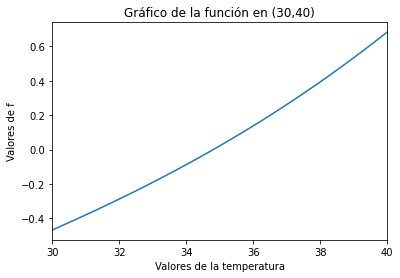

In [192]:
x_axis = np.arange(30, 40, 0.01)
y_axis = [f_eval_ta_s(x) for x in x_axis]
plt.plot(x_axis, y_axis)
plt.title("Gráfico de la función en (30,40)")
plt.xlabel("Valores de la temperatura")
plt.ylabel("Valores de f")
plt.xlim(30,40);

Como observamos en el gráfico de la función, vemos que alcanza una raíz $p$ aproximadamente en el intervalo $(30, 40)$. Utilizaremos este invervalo para para los métodos correspondientes.

### Método de la bisección

#### Código del método

Aplicamos el método de la bisección a la función $f$, y de yapa aproximamos la velocidad de convergencia $\lambda$ utilizando el último valor obtenido el último valor obtenido tras las iteraciones del método, utilizando la ecuación:
- $\lambda \approx \frac{|x_{final} - x_{n}|}{|x_{final} - x_{n-1}|^\alpha}$

In [246]:
aproximar_lambda = lambda indice: abs((resultados["Aproximación"].iloc[-1] - resultados["Aproximación"].iloc[indice]))/ \
  abs((resultados["Aproximación"].iloc[-1] - resultados["Aproximación"].iloc[indice-1]))
  
aproximaciones_lambda = lambda resultados: [0] + [aproximar_lambda(indice) for indice in resultados.index[1:]]

def bisect(f, a: float, b: float, tol: float, max_iteraciones:int = 100):
  resultados = pd.DataFrame(columns = ["Aproximación", "Error relativo"])
  a = np.float32(a)
  b = np.float32(b)
  aproximacion = (b+a)/2
  while np.absolute((b - a) / b) > tol and len(resultados) < max_iteraciones:    
    aproximacion = (b+a)/2
    if f(aproximacion) * f(a) < 0:
      b = aproximacion
    else:
      a = aproximacion
    resultados.loc[len(resultados.index)] = [aproximacion, np.absolute(((b-a)/b))] 

  resultados["Lambda"] = aproximaciones_lambda(resultados)
  
  return aproximacion, resultados

#### Aplicación en el problema presentado y análisis de los resultados

In [233]:
aproximacion, resultados = bisect(f_eval_ta_s, a = 30, b = 40, tol = 10**-8, max_iteraciones=1000)
resultados

,Aproximación,Error relativo,Lambda
0,35.000000,1.428571e-01,0.000000
1,32.500000,7.142857e-02,11.606050
2,33.750000,3.571429e-02,0.456919
3,34.375000,1.785714e-02,0.405714
4,34.687500,8.928571e-03,0.267605
5,34.843750,4.484305e-03,0.368423
6,34.765625,2.242152e-03,0.857136
7,34.804688,1.122334e-03,0.083338
8,34.785156,5.611672e-04,5.499653
9,34.794922,2.805836e-04,0.409085


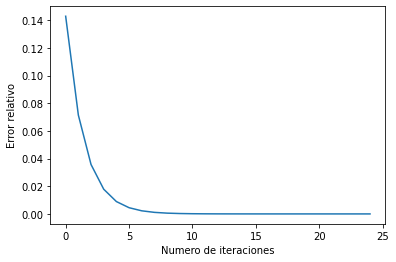

In [234]:
plt.plot(resultados.index, resultados["Error relativo"])
plt.xlabel("Numero de iteraciones")
plt.ylabel("Error relativo");

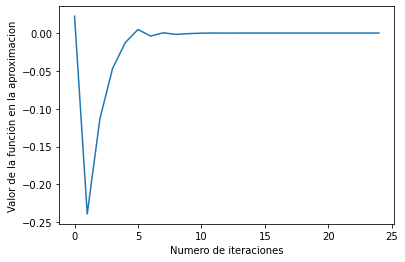

In [235]:
plt.plot(resultados.index, [f_eval_ta_s(aproximacion) for aproximacion in resultados["Aproximación"]])
plt.xlabel("Numero de iteraciones")
plt.ylabel("Valor de la función en la aproximacion");


### Método del punto fijo

#### Verificación de las hipótesis de convergencia

Necesitamos una función $g(x)$ tal que $g \in C¹ \ \forall \ x  \in I$, y que cumpla con las dos hipótesis de convergencia del punto fijo:
- $g(x) \in I \ \forall x \in I$
- $|g'(x)| < 1 \ \forall x \in I$

In [177]:
g = Ta_s_sim - f
g

T_a^s + 1 - (A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)))

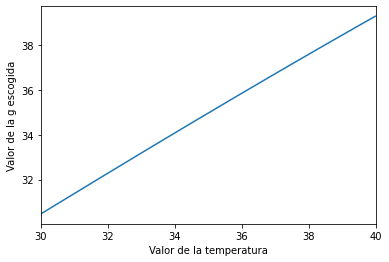

In [190]:
g_eval = sp.lambdify([U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim, Ta_s_sim], g)
g_eval_ta_s = lambda Ta_s: g_eval(U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e,Ta_s)
x_axis = np.arange(30,40,0.01)
y_axis = [g_eval_ta_s(x) for x in x_axis]
plt.plot(x_axis, y_axis)
plt.xlabel("Valor de la temperatura")
plt.ylabel("Valor de la g escogida")
plt.xlim(30,40);

In [183]:
max(y_axis), min(y_axis)

(39.30845674487209, 30.46633766913846)

Vemos que la función $g$ escogida cumple con la primer hipótesis. Verificamos que cumple con la segunda

In [185]:
g_prima = sp.diff(g, Ta_s_sim)
g_prima

1 + (T_a^s - T_w^s)*(Cp_a*m_a/(Cp_w*m_w*(T_a^s - T_w^s)) - (-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)**2)*(A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s))**2) - (A*Cp_a*U*m_a/(Cp_w*m_w) - 1)/(Cp_a*m_a*(T_a^e - T_a^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s))) - (A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)**2*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)))

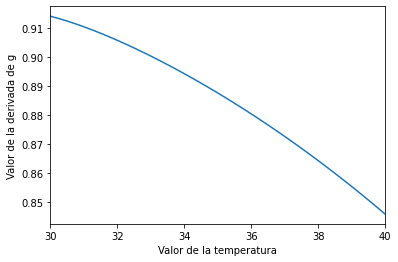

In [189]:
g_prima_eval = sp.lambdify([U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim, Ta_s_sim], g_prima)
g_prima_eval_ta_s = lambda Ta_s: g_prima_eval(U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e,Ta_s)
x_axis = np.arange(30,40,0.01)
y_axis = [g_prima_eval_ta_s(x) for x in x_axis]
plt.plot(x_axis, y_axis)
plt.xlabel("Valor de la temperatura")
plt.ylabel("Valor de la derivada de g")
plt.xlim(30,40);

In [193]:
max(y_axis), min(y_axis)

(0.681543255129468, -0.4663376691384621)

Escogiendo $m$ = 0.7, notamos claramente que $g'(x) < m < 1 \ \forall x \in I$. Luego la función que elegimos cumple también la segunda hipótesis de convergencia del punto fijo. Por lo tanto, para el intervalo $I = (30,40)$ escogido, y para la $g$ que hemos estado analizando, el método del punto fijo converge.

#### Código del método del punto fijo

In [247]:
def fixed_point_iteration(g, a, b, tol, maximo_iteraciones = 100):
  resultados = pd.DataFrame(columns=["Aproximación", "Error Relativo"])
  error_relativo = lambda a,b: np.abs((b-a)/b)
  aproximacion_actual = g((a+b)/2)
  aproximacion_anterior = (a+b)/2
  resultados.loc[len(resultados)] = [aproximacion_actual, error_relativo(a,b)]
  error_relativo = lambda a,b: np.abs((b-a)/b)
  while error_relativo(aproximacion_actual, aproximacion_anterior) > tol and len(resultados) < maximo_iteraciones:
    aproximacion_anterior = aproximacion_actual
    aproximacion_actual = g(aproximacion_actual)
    resultados.loc[len(resultados)] = [aproximacion_actual, error_relativo(aproximacion_actual, aproximacion_anterior)]

  resultados["Lambda"] = aproximaciones_lambda(resultados)

  return aproximacion_actual, resultados

#### Aplicación en el problema presentado y análisis de los resultados

In [248]:
aproximacion, resultados = fixed_point_iteration(g_eval_ta_s,30,40,10**-8)
resultados

,Aproximación,Error Relativo,Lambda
0,34.977826,2.500000e-01,0.000000
1,34.958145,5.626753e-04,0.888265
2,34.940673,4.997835e-04,0.888332
3,34.925161,4.439577e-04,0.888392
4,34.911387,3.943961e-04,0.888445
...,...,...,...
90,34.801687,1.563479e-08,0.750343
91,34.801686,1.389731e-08,0.704251
92,34.801686,1.235291e-08,0.626721
93,34.801685,1.098014e-08,0.470583


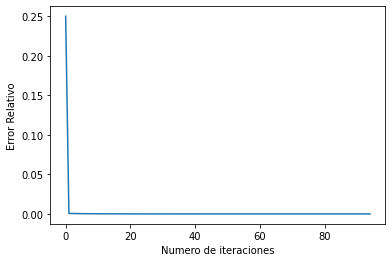

In [224]:
plt.plot(resultados.index, resultados["Error Relativo"])
plt.xlabel("Numero de iteraciones")
plt.ylabel("Error Relativo");

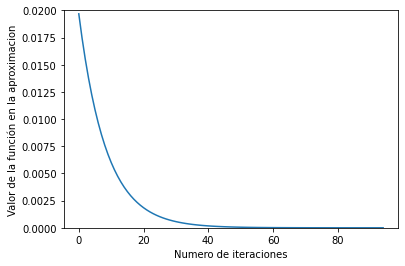

In [225]:
plt.plot(resultados.index, [f_eval_ta_s(aproximacion) for aproximacion in resultados["Aproximación"]])
plt.xlabel("Numero de iteraciones")
plt.ylabel("Valor de la función en la aproximacion")
plt.ylim(0,0.02);

### Método de Newton-Raphson

#### Análisis de la convergencia del método

In [250]:
f_prima = sp.diff(f, Ta_s_sim)
f_prima

-(T_a^s - T_w^s)*(Cp_a*m_a/(Cp_w*m_w*(T_a^s - T_w^s)) - (-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)**2)*(A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s))**2) + (A*Cp_a*U*m_a/(Cp_w*m_w) - 1)/(Cp_a*m_a*(T_a^e - T_a^s)*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s))) + (A*U*(-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^e) - T_a^s + T_w^e)/(Cp_a*m_a*(T_a^e - T_a^s)**2*log((-Cp_a*m_a*(T_a^e - T_a^s)/(Cp_w*m_w) + T_a^e - T_w^s)/(T_a^s - T_w^s)))

Sabemos que:
- Sea $f \in C^2 \ \forall x \in I, f'(x) \neq 0 \ \forall x \in I , \exists p \in I: f(p) = 0$, entonces el *método de Newton-Raphson* converge a la raíz $p$ tomando cualquier $x_0 \in I$ como valor inicial.

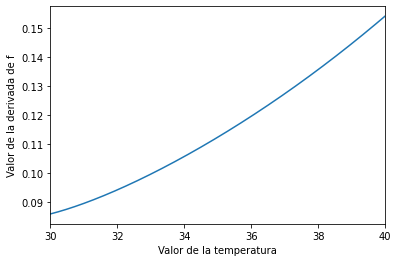

In [251]:
f_prima_eval = sp.lambdify([U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim, Ta_s_sim], f_prima)
f_prima_eval_ta_s = lambda Ta_s: f_prima_eval(U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e,Ta_s)
x_axis = np.arange(30,40,0.01)
y_axis = [f_prima_eval_ta_s(x) for x in x_axis]
plt.plot(x_axis, y_axis)
plt.xlabel("Valor de la temperatura")
plt.ylabel("Valor de la derivada de f")
plt.xlim(30,40);

Vemos que $f(x) \neq 0 \ \forall x \in I$, luego se cumple la segunda hipótesis. Como además observamos que la derivada es continua, sabemos que al menos la función es $C^1$ en $I$

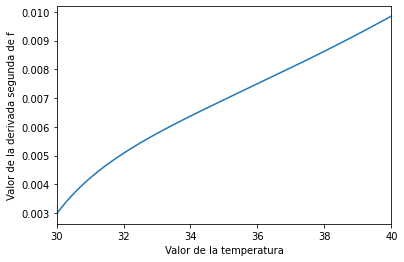

In [258]:
f_prima_prima = sp.diff(f_prima, Ta_s_sim)
f_prima_prima_eval = sp.lambdify([U_sim, A_sim, mw_sim, Cpw_sim, Tw_e_sim, Tw_s_sim, ma_sim, Cpa_sim, Ta_e_sim, Ta_s_sim], f_prima_prima)
f_prima_prima_eval_ta_s = lambda Ta_s: f_prima_prima_eval(U,A,mw,Cpw,Tw_e,Tw_s,ma,Cpa,Ta_e,Ta_s)
x_axis = np.arange(30,40,0.01)
y_axis = [f_prima_prima_eval_ta_s(x) for x in x_axis]
plt.plot(x_axis, y_axis)
plt.xlabel("Valor de la temperatura")
plt.ylabel("Valor de la derivada segunda de f")
plt.xlim(30,40);

Vemos que la segunda derivada también es continua. Por lo tanto, podemos asumir con relativa tranquilidad que nuestra función $f$ es $C^2 \ \forall x \in I$. Por lo tanto, podemos aplicar el método de Newton-Raphson

### Método de Steffensen